In [2]:
%load_ext lab_black

In [3]:
import math
from typing import Union

import torch as th
import torch.nn.functional as F
import triton
import triton.language as tl
from kitsu.utils.utils import cummul
from torch import Tensor, nn
from torch.nn.parameter import Parameter

from fast_gem.functional import triton_utils as tu

In [4]:
th.cuda.set_device(6)

In [5]:
def gem_torch_old(x, p=3, eps=1e-6, work_with_tokens=False):
    if work_with_tokens:
        x = x.permute(0, 2, 1)
        # unseqeeze to maintain compatibility with Flatten
        return F.avg_pool1d(x.clamp(min=eps).pow(p), (x.size(-1))).pow(1.0 / p).unsqueeze(3)
    else:
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)


def gem_torch(x: Tensor, p=3, eps=1e-6, dim=-2):
    """
    input:
    - x: ... ... (= m n)
    return:
    - y: ... (= m)
    """
    yshape = x.shape[:dim]
    M = cummul(*x.shape[:dim])
    N = cummul(*x.shape[dim:])
    x = x.view(M, N)  # m n

    x = th.clamp_min(x, eps).pow_(p)
    x = x.mean(-1)  # adaptive average pooling
    x = x.pow_(1.0 / p)

    return x.view(*yshape)

In [11]:
class GeMOps(th.autograd.Function):
    @staticmethod
    @triton.jit
    def forward_kernel(x_ptr, y_ptr, p, eps, M, N, IS_P_TENSOR: tl.constexpr, BLK_M: tl.constexpr, BLK_N: tl.constexpr):
        pid = tl.program_id(0)
        offs_m = pid * BLK_M + tl.arange(0, BLK_M)  # m
        offs_n = tl.arange(0, BLK_N)  # n
        x_ptrs = x_ptr + offs_m[:, None] * N + offs_n[None, :]  # m n

        if IS_P_TENSOR:
            p = tl.load(p)

        y = tl.zeros((BLK_M,), dtype=tl.float32)
        for n in range(tl.cdiv(N, BLK_N)):
            mask = (offs_m[:, None] < M) & (offs_n[None, :] < N - n * BLK_N)
            x = tl.load(x_ptrs, mask=mask, other=0.0)  # m n

            # calculate adaptive average pooling
            x = tl.where((x < eps) & mask, eps, x)
            x = tu.pow(x, p)  # m n
            y += tl.sum(x, 1)  # m

            x_ptrs += BLK_N

        y /= N
        y = tu.pow(y, 1 / p)

        y_ptrs = y_ptr + offs_m
        tl.store(y_ptrs, y, mask=offs_m < M)

    @staticmethod
    @triton.jit
    def backward_kernel(
        x_ptr, y_ptr, p, dy_ptr, dx_ptr, dp_ptr, eps, M, N, IS_P_TENSOR: tl.constexpr, BLK_M: tl.constexpr, BLK_N: tl.constexpr
    ):
        pid = tl.program_id(0)
        offs_m = pid * BLK_M + tl.arange(0, BLK_M)  # m
        offs_n = tl.arange(0, BLK_N)  # n
        x_ptrs = x_ptr + offs_m[:, None] * N + offs_n[None, :]  # m n
        dx_ptrs = dx_ptr + offs_m[:, None] * N + offs_n[None, :]  # m n
        mask_m = offs_m < M

        if IS_P_TENSOR:
            p = tl.load(p)

        # calculate y-level grad
        y = tl.load(y_ptr + offs_m, mask=mask_m)
        dy = tl.load(dy_ptr + offs_m, mask=mask_m)

        if IS_P_TENSOR:
            dp = tl.where(mask_m, -tl.log(y) / p * y * dy, 0.0)
            dp = tl.sum(dp, axis=0)
        dy = dy / p * y / (tu.pow(y, p) * N)  # m

        # re-calculate x for x-level grad
        for n in range(tl.cdiv(N, BLK_N)):
            mask = mask_m[:, None] & (offs_n[None, :] < N - n * BLK_N)
            x = tl.load(x_ptrs, mask=mask, other=0.0)  # m n

            # calculate adaptive average pooling
            x_ = tl.where((x < eps) & mask, eps, x)
            # x = tu.pow(x, p)
            # y += tl.sum(x, 1)  # m

            dx = tl.zeros((BLK_M, BLK_N), dtype=dy.dtype) + dy[:, None]  # m n

            if IS_P_TENSOR:
                dp_tmp = tl.where(mask, tu.pow(x_, p) * tl.log(x_) * dx, 0.0)
                dp += tl.sum(tl.sum(dp_tmp, axis=1), axis=0)

            dx *= p * tu.pow(x_, p - 1)
            dx = tl.where((x < eps) & mask, 0.0, dx)

            tl.store(dx_ptrs, dx, mask=mask)
            x_ptrs += BLK_N
            dx_ptrs += BLK_N

        if IS_P_TENSOR:
            tl.atomic_add(dp_ptr, dp)

    @staticmethod
    def forward(ctx, x: Tensor, p: Union[float, Tensor] = 3.0, eps: float = 1e-6, dim: int = -2):
        ctx.is_p_tensor = isinstance(p, Tensor)
        M = cummul(*x.shape[:dim])
        N = cummul(*x.shape[dim:])
        y = x.new_empty(x.shape[:dim])

        BLK_N = max(min(triton.next_power_of_2(N), 4096), 32)
        BLK_M = max(1, 1024 // BLK_N)
        grid = lambda meta: (triton.cdiv(M, meta["BLK_M"]),)
        GeMOps.forward_kernel[grid](x, y, p, eps, M, N, IS_P_TENSOR=ctx.is_p_tensor, BLK_M=BLK_M, BLK_N=BLK_N)

        if ctx.is_p_tensor:
            ctx.save_for_backward(x, p, y)
            ctx.params = eps, dim
        else:
            ctx.save_for_backward(x, y)
            ctx.params = p, eps, dim
        return y

    @staticmethod
    def backward(ctx, dy: Tensor):
        if ctx.is_p_tensor:
            x, p, y = ctx.saved_tensors
            eps, dim = ctx.params
        else:
            x, y = ctx.saved_tensors
            p, eps, dim = ctx.params

        M = cummul(*x.shape[:dim])
        N = cummul(*x.shape[dim:])
        dx = th.empty_like(x)
        dp = None
        if ctx.is_p_tensor:
            dp = th.zeros_like(p)

        BLK_N = max(min(triton.next_power_of_2(N), 4096), 32)
        BLK_M = max(1, 1024 // BLK_N)
        grid = lambda meta: (triton.cdiv(M, meta["BLK_M"]),)
        GeMOps.backward_kernel[grid](x, y, p, dy, dx, dp, eps, M, N, IS_P_TENSOR=ctx.is_p_tensor, BLK_N=BLK_N, BLK_M=BLK_M)
        return dx, dp, None, None


def gem(x: Tensor, p: Union[float, Tensor] = 3.0, eps: float = 1e-6, dim: int = -2):
    try:
        assert x.device != th.device("cpu")
        return GeMOps.apply(x, p, eps, dim)
    except:
        return gem_torch(x, p, eps, dim)
    # return GeMOps.apply(x, p, eps, dim)

In [7]:
B, M, H, W = 5, 10, 20, 40
x = th.rand(B, M, H, W, device="cuda", requires_grad=True)
p = th.full((1,), 2.0, device="cuda", requires_grad=True)
y_gt = th.randn(B, M, device="cuda")

In [8]:
y_pth = gem_torch(x, p, dim=-2)
y_pth.backward(y_gt, retain_graph=True)
x_grad_pth, x.grad = x.grad, None
p_grad_pth, p.grad = p.grad, None

In [12]:
y_tri = gem(x, p, dim=-2)
y_tri.backward(y_gt, retain_graph=True)
x_grad_tri, x.grad = x.grad, None
p_grad_tri, p.grad = p.grad, None

In [13]:
th.allclose(y_pth, y_tri)

True

In [14]:
th.allclose(x_grad_pth, x_grad_tri)

True

In [15]:
th.allclose(p_grad_pth, p_grad_tri)

True

# Benchmark

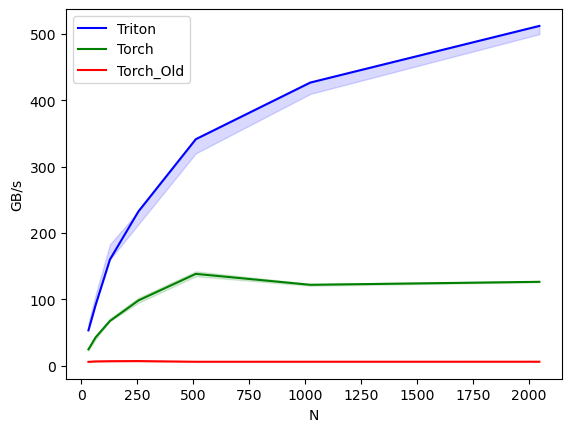

a:
        N      Triton       Torch  Torch_Old
0    32.0   53.333331   24.615385   5.818182
1    64.0   91.428570   42.666668   6.464647
2   128.0  160.000000   67.368424   6.808510
3   256.0  232.727271   98.461540   6.994536
4   512.0  341.333342  138.378372   5.946574
5  1024.0  426.666652  121.904763   5.981308
6  2048.0  512.000013  126.419756   6.014684


In [19]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[16 * 2**i for i in range(1, 8)],
        x_log=False,
        line_arg="provider",
        line_vals=["triton", "torch", "torch_old"],
        line_names=["Triton", "Torch", "Torch_Old"],
        styles=[("blue", "-"), ("green", "-"), ("red", "-")],
        ylabel="GB/s",
        plot_name="a",
        args={"B": 2, "M": 64, "p": 3.0, "W": 64},
    )
)
def benchmark(B, M, N, p, W, provider):
    x = th.rand(B, M, N, H, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gem_torch(x, p, dim=-2),
            quantiles=quantiles,
        )
    elif provider == "torch_old":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gem_torch_old(x, p)[:, :, 0, 0],
            quantiles=quantiles,
        )
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: gem(x, p, dim=-2),
            quantiles=quantiles,
        )

    gbps = lambda ms: (x.nelement() * x.element_size()) * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)